In [1]:
import numpy as np
from tqdm import trange
from datasets import fetch_mnist

# This was built using the 3blue1brown video series
# https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

In [2]:
# Load the mnist dataset
images_train, labels_train, images_test, labels_test = fetch_mnist()

In [3]:
def sigmoid(x: np.ndarray):
    return 1.0 / (1.0 + np.exp(-x))


def layer_init(m, h):
    ret = np.random.uniform(-1.0, 1.0, size=(m, h)) / np.sqrt(m * h)
    return ret.astype(np.float32)


def d_sigmoid(x: np.ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def loss_function(pred: np.ndarray, target: np.ndarray):
    return np.square(pred - target).mean(axis=0)


def d_loss_function(pred: np.ndarray, target: np.ndarray):
    return 2 * (pred - target) / pred.shape[0]


class Network:
    def __init__(self):
        self.input_layer = layer_init(128, 28 * 28)
        self.output_layer = layer_init(10, 128)

    def forward(self, x: np.ndarray):
        x = self.input_layer.dot(x.T)
        x = sigmoid(x)
        x = self.output_layer.dot(x)
        x = sigmoid(x)
        return x.T

    def backward(self, x: np.ndarray, y: np.ndarray):
        x_layer1 = self.input_layer.dot(x.T)
        x_sigmoid1 = sigmoid(x_layer1)
        x_layer2 = self.output_layer.dot(x_sigmoid1)
        x_sigmoid2 = sigmoid(x_layer2)

        delta_2 = (
            d_loss_function(x_sigmoid2, y.T) * d_sigmoid(x_layer2) / x_sigmoid2.shape[1]
        )
        d_layer2 = delta_2.dot(x_sigmoid1.T)

        delta_1 = d_sigmoid(x_layer1) * self.output_layer.T.dot(delta_2)
        d_layer1 = delta_1.dot(x)
        return d_layer1, d_layer2

    def update_params(self, dl1, dl2, lr):
        self.input_layer = self.input_layer - lr * dl1
        self.output_layer = self.output_layer - lr * dl2


In [4]:
# Training

BATCH_SIZE = 128
model = Network()
for i in (t := trange(1000)):
    sample = np.random.randint(0, images_train.shape[0], size=(BATCH_SIZE))

    input = images_train[sample].reshape((-1, 28 * 28))

    target = np.zeros((labels_train[sample].size, 10), dtype=np.float32)
    target[range(labels_train[sample].size), labels_train[sample]] = 1.0

    dl1, dl2 = model.backward(input, target)
    model.update_params(dl1, dl2, 0.1)


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/f0/bcsr84m12mg20tdcd868wcnm0000gn/T/ipykernel_47364/2913633973.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
100%|██████████| 1000/1000 [00:01<00:00, 578.77it/s]


In [5]:
# Evaluation
def eval():
    X = images_test[:].reshape((-1, 28 * 28))
    Y = labels_test[:]
    out = model.forward(X)
    accuracy = (np.argmax(out, axis=1) == Y).astype(np.float32).mean()
    return accuracy


print(f"accuracy: {eval()}")


accuracy: 0.8948000073432922


/var/folders/f0/bcsr84m12mg20tdcd868wcnm0000gn/T/ipykernel_47364/2913633973.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


From label: 7
From NN: [7]


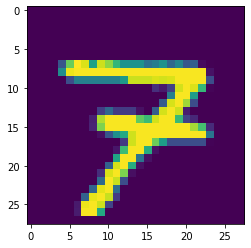

In [6]:
# Testing
import matplotlib.pyplot as plt

IDX = 64

fig, ax = plt.subplots()
ax.imshow(images_test[IDX])

x = images_test[IDX].reshape(-1, 28 * 28).astype(np.float32)
out = model.forward(x)

print(f"From label: {labels_test[IDX]}")
print(f"From NN: {np.argmax(out, axis=1)}")
